## Imports and utility functions

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from tkinter import BOTH, RIGHT
from collections import deque
import time


In [22]:
# Interface to show image files
def imshow2(img, title="Image") :
    cv2.imshow(title, img)
    input = cv2.waitKey(0)

    # press x in the opened window to destroy all windows
    if input == ord('x') :
        cv2.destroyAllWindows()

def plt_imshow2(img, title=""):
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title != "" :
        plt.title(title)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    plt.show()

## Import Image

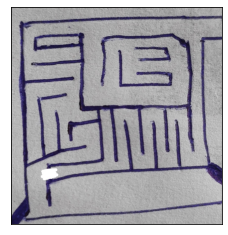

In [23]:
img_name = "maze4.jpeg"
img = cv2.imread(img_name)

plt_imshow2(img)

## Cleanup 1

In [24]:
img_size = (400,500)

gblur_kernel = (9,9)
gblur_alpha = 0.5

thresh = 150

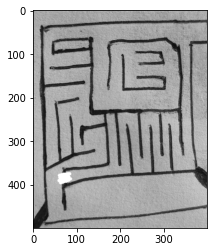

In [25]:
img = cv2.resize(img, img_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap="gray")


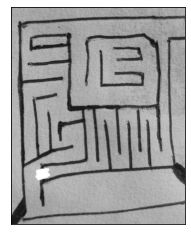

In [26]:
# blur
img = cv2.GaussianBlur(img, gblur_kernel, gblur_alpha)
plt_imshow2(img)

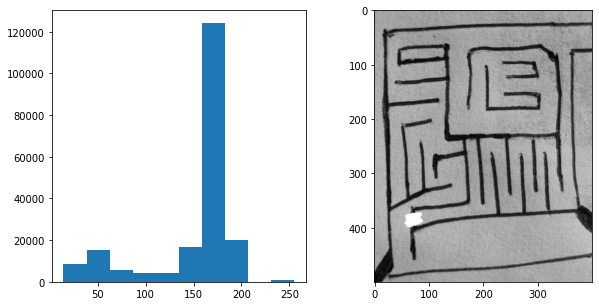

In [27]:
# generate image histogram
hist = np.histogram(img.flatten())
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax[0].hist(img.flatten())
ax[1].imshow(img, cmap="gray")

In [28]:
def show_threshhold(img, thresh) :
    img2 = img > thresh 
    plt.imshow(img2, cmap='gray')
    return img2

## Binarize

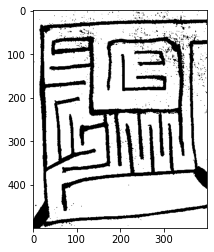

In [29]:
bin_img = show_threshhold(img, thresh)

In [30]:
print(bin_img.shape)
print(bin_img)

(500, 400)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


In [31]:
def export(bin_img) :
    file = open("out.txt", "w")
    row, col = bin_img.shape 

    file.write(str(row) + " " + str(col) + "\n")

    for i in bin_img :
        for j in i :
            if j :
                file.write("1 ")
            else :
                file.write("0 ")
        file.write("\n")
export(bin_img)

## Put Maze in GUI Window

In [32]:

class CellManager :
    def __init__(self, nrow, ncol):
        self.padding = 5
        self.spacing = 0
        self.startx = 0 + self.padding
        self.starty = 0 + self.padding 
        
        self.endx = -1
        self.endy = -1

        self.nrow = nrow
        self.ncol = ncol

        self.cellw = -1
        self.cellh = -1

    def set_dimensions(self, mainw, mainh):
        self.endx = mainw - self.padding
        self.endy = mainh - self.padding 

        self.cellw = (self.endx - self.startx - self.ncol*self.spacing) // self.ncol
        self.cellh = (self.endy - self.starty - self.nrow*self.spacing) // self.nrow

    def get_cell_coords(self, r, c):
        stx = self.startx + c*(self.cellw + self.spacing) 
        sty = self.starty + r*(self.cellh + self.spacing)
        endx = stx + self.cellw 
        endy = sty + self.cellh 

        return stx, sty, endx, endy 

    def fill(self, canvas, r, c, color='#00ff00'):
        a,b,c,d = self.get_cell_coords(r,c)
        canvas.create_rectangle(a,b,c,d,fill=color, outline='')



    


In [72]:
nrow = bin_img.shape[0]
ncol = bin_img.shape[1]
WIN_WIDTH = 1200
WIN_HIEGHT = 900

wall_color = '#111111'
path_color = '#eeeeee'
visited_color = '#99dd88'
best_path_color = 'red'

root = tk.Tk()

canvas = tk.Canvas(root, height=WIN_HIEGHT, width=WIN_WIDTH, bg = 'gray')

canvas.pack(fill=BOTH)
cm = CellManager(nrow, ncol)
cm.set_dimensions(WIN_WIDTH, WIN_HIEGHT)

for i in range(0, nrow):
    for j in range(0, ncol):
        if bin_img[i][j] :
            # True => walkable
            cm.fill(canvas, i, j, path_color)
        else :
            cm.fill(canvas, i, j, wall_color)




In [69]:
max_dist = 2*(nrow+ncol)

init_red = 110
init_green = 0
init_blue = 90

#niter = 0

def get_visited_color(dist):

    # Todo : Why error ??
    #niter += 1
    
    r = init_red
    b = init_blue
    g = init_green + int(dist*255/max_dist)

    if(g>255) :
        g = 255
    
    if dist % 100 == 0 :
        print("dist = ", dist, " g = ", g)

    return rgb_tuple_to_hex(tuple((r,g,b)))



def rgb_tuple_to_hex(rgb) :
    return "#%02x%02x%02x" % rgb

In [60]:

start_pos = (40,399)
end_pos = (473, 50)
# function that does bfs

diff = [ (-1,0), (1,0), (0,-1), (0,1)]

def is_valid(r,c) :
    return r>=0 and c>=0 and r<nrow and c<ncol

def bfs_maze_solver():

    delay1 = 0.001 
    step = 500

    # make visited array, and use queue
    visited = np.full(bin_img.shape, False, dtype=bool)
    dist = np.full(bin_img.shape, -1, dtype = int)
    bfs_queue = deque()

    bfs_queue.append(start_pos)
    dist[start_pos] = 0

    iter = 0

    while len(bfs_queue) > 0 :
        iter+=1

        if iter % step == 0 :
            canvas.update()
            #print(iter, " iterations done")
            #time.sleep(delay1)
        

        curpos = bfs_queue.popleft()
        x,y = curpos


        assert dist[x,y] != -1

        if curpos == end_pos :
            break
        #assert visited[x,y] == False 
        if(visited[x,y]) :
            continue

        visited[x,y] = True 
        #cm.fill(canvas, x, y, visited_color) 
        cm.fill(canvas, x, y, get_visited_color(dist[x,y])) 


        # all its neighbours
        for p in diff:
            curx = x + p[0]
            cury = y + p[1]

            # is in bounds and not visited yet, and is walkable 
            if is_valid(curx, cury) and ( not visited[curx, cury]) and (bin_img[curx, cury] == True):
                # put in queue
                assert visited[curx, cury] == False
                dist[curx, cury] = dist[x,y] + 1
                bfs_queue.append((curx, cury))

        
    # now we have the distance
    # find the way back
    iter = 0
    step2 = 50
    delay2 = 0.3
    curpos = end_pos
    while curpos != start_pos :
        iter += 1 
        if iter % step2 == 0 :
            canvas.update()
            time.sleep(delay2)
        # draw curpos as red
        cm.fill(canvas, curpos[0], curpos[1], best_path_color)
        curdist = dist[curpos]
        # choose pos with dist == curdist-1
        for p in diff :
            newpos = curpos[0] + p[0], curpos[1] + p[1]
            if is_valid(newpos[0], newpos[1]) and (dist[newpos] == curdist - 1) :
                curpos = newpos
                break 




In [73]:
start_button = tk.Button(root, text="Start", command=bfs_maze_solver)
start_button.pack(side=RIGHT )
root.mainloop()

dist =  0  g =  0
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =  14
dist =  100  g =